In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# Tensorflow and keras tuning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from numpy.random import seed
seed(42)
tf.random.set_seed(777)

In [2]:
df = pd.read_csv('../pool_data_202211111622.csv')

In [3]:
df.head()

,pool_id,time_stamp,salinity,flow switch,flow meter,turbidity,ORP,PH,TDS,Pressure in tank,...,Shw msg,Drain,Human Counter,temperature,water level,cppm,phfeedtime,orpfeedtime,bather in from mens,bather in from ladies
0,10001,2022-11-01 11:01:16.220 -0400,287.175,NaN,NaN,9.51440,774.049,7.41573,287.175,NaN,...,NaN,0.0,0.0,74.2574,500.0,NaN,NaN,NaN,NaN,NaN
1,10001,2022-11-01 11:01:26.323 -0400,287.175,NaN,NaN,9.35767,773.597,7.41573,287.175,NaN,...,NaN,0.0,0.0,74.2574,500.0,NaN,NaN,NaN,NaN,NaN
2,10001,2022-11-01 11:01:36.386 -0400,287.121,NaN,NaN,9.35767,773.869,7.41889,287.121,NaN,...,NaN,0.0,0.0,74.2574,500.0,NaN,NaN,NaN,NaN,NaN
3,10001,2022-11-01 11:01:46.498 -0400,287.248,NaN,NaN,8.57397,773.959,7.41193,287.248,NaN,...,NaN,0.0,0.0,74.2574,500.0,NaN,NaN,NaN,NaN,NaN
4,10001,2022-11-01 11:01:56.554 -0400,287.175,NaN,NaN,8.88745,773.597,7.41699,287.157,NaN,...,NaN,0.0,0.0,74.2574,500.0,NaN,NaN,NaN,NaN,NaN


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pool_id,43635.0,10001.000000,0.000000,10001.000000,10001.00000,10001.00000,10001.00000,10001.00000
salinity,43604.0,277.844371,7.997543,0.000000,273.95500,277.39100,281.46100,557.57500
flow switch,31.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000
flow meter,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
turbidity,43604.0,21.799282,71.822268,-4375.260000,22.02250,27.35210,33.30830,46.94560
ORP,43635.0,745.472058,53.136355,0.000000,741.40700,758.40600,766.36400,3002.87000
PH,43635.0,6.334087,2.650337,-11.099353,7.38977,7.41636,7.44927,20.74010
TDS,43604.0,277.844096,7.997437,0.000000,273.95500,277.39100,281.46100,557.57500
Pressure in tank,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure in,43604.0,2.518673,0.135535,-5.925750,2.51212,2.52206,2.52387,2.54503


In [5]:
deprecated_col = ['flow switch', 'flow meter', 'Pressure in tank', 'Shw msg', 'phfeedtime', 'orpfeedtime']

df = df.drop(deprecated_col, axis=1)
df.head()

,pool_id,time_stamp,salinity,turbidity,ORP,PH,TDS,Pressure in,Pressure out,Pump RPM,...,dis_feeder,ph_feeder,Fresh water,Drain,Human Counter,temperature,water level,cppm,bather in from mens,bather in from ladies
0,10001,2022-11-01 11:01:16.220 -0400,287.175,9.51440,774.049,7.41573,287.175,2.53581,2.53346,NaN,...,NaN,NaN,0.0,0.0,0.0,74.2574,500.0,NaN,NaN,NaN
1,10001,2022-11-01 11:01:26.323 -0400,287.175,9.35767,773.597,7.41573,287.175,2.53508,2.53382,NaN,...,NaN,NaN,0.0,0.0,0.0,74.2574,500.0,NaN,NaN,NaN
2,10001,2022-11-01 11:01:36.386 -0400,287.121,9.35767,773.869,7.41889,287.121,2.53526,2.53382,NaN,...,NaN,NaN,0.0,0.0,0.0,74.2574,500.0,NaN,NaN,NaN
3,10001,2022-11-01 11:01:46.498 -0400,287.248,8.57397,773.959,7.41193,287.248,2.53545,2.53382,NaN,...,NaN,NaN,0.0,0.0,0.0,74.2574,500.0,NaN,NaN,NaN
4,10001,2022-11-01 11:01:56.554 -0400,287.175,8.88745,773.597,7.41699,287.157,2.53508,2.53382,NaN,...,NaN,NaN,0.0,0.0,0.0,74.2574,500.0,NaN,NaN,NaN


Lets tidy up our data. cppm is calculated from ORP and thus is not necessary. We also do not have data for bather in from mens and bather in from ladies. We will remove these as well then look at missing values. Also `TDS` and `salinity` are always the same so we will keep just one. We will also drop the columns with no values or no count.

In [6]:
# Drop columns that have no data or are calculate from other columns

unnecessary_data = ['cppm', 'bather in from mens', 'bather in from ladies', 'Pump RPM', 'dis_feeder', 'ph_feeder', 
                   'Fresh water', 'Drain', 'salinity']

df = df.drop(unnecessary_data, axis=1)
df.columns

Index(['pool_id', 'time_stamp', 'turbidity', 'ORP', 'PH', 'TDS', 'Pressure in',
       'Pressure out', 'pump current', 'Human Counter', 'temperature',
       'water level'],
      dtype='object')

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pool_id,43635.0,10001.000000,0.000000,10001.000000,10001.00000,10001.00000,10001.00000,10001.00000
turbidity,43604.0,21.799282,71.822268,-4375.260000,22.02250,27.35210,33.30830,46.94560
ORP,43635.0,745.472058,53.136355,0.000000,741.40700,758.40600,766.36400,3002.87000
PH,43635.0,6.334087,2.650337,-11.099353,7.38977,7.41636,7.44927,20.74010
TDS,43604.0,277.844096,7.997437,0.000000,273.95500,277.39100,281.46100,557.57500
Pressure in,43604.0,2.518673,0.135535,-5.925750,2.51212,2.52206,2.52387,2.54503
Pressure out,43604.0,2.520375,0.057463,0.000000,2.51085,2.52044,2.52224,5.92575
pump current,43604.0,14.425126,892.269724,0.000000,0.00000,0.00000,0.00000,56183.10000
Human Counter,43604.0,7.148587,5.726768,0.000000,0.00000,6.00000,15.00000,15.00000
temperature,43635.0,74.219929,1.373040,0.000000,74.25740,74.25740,74.25740,74.25740


In [8]:
df = df.set_index('time_stamp')
df = df.sort_values(by='time_stamp')

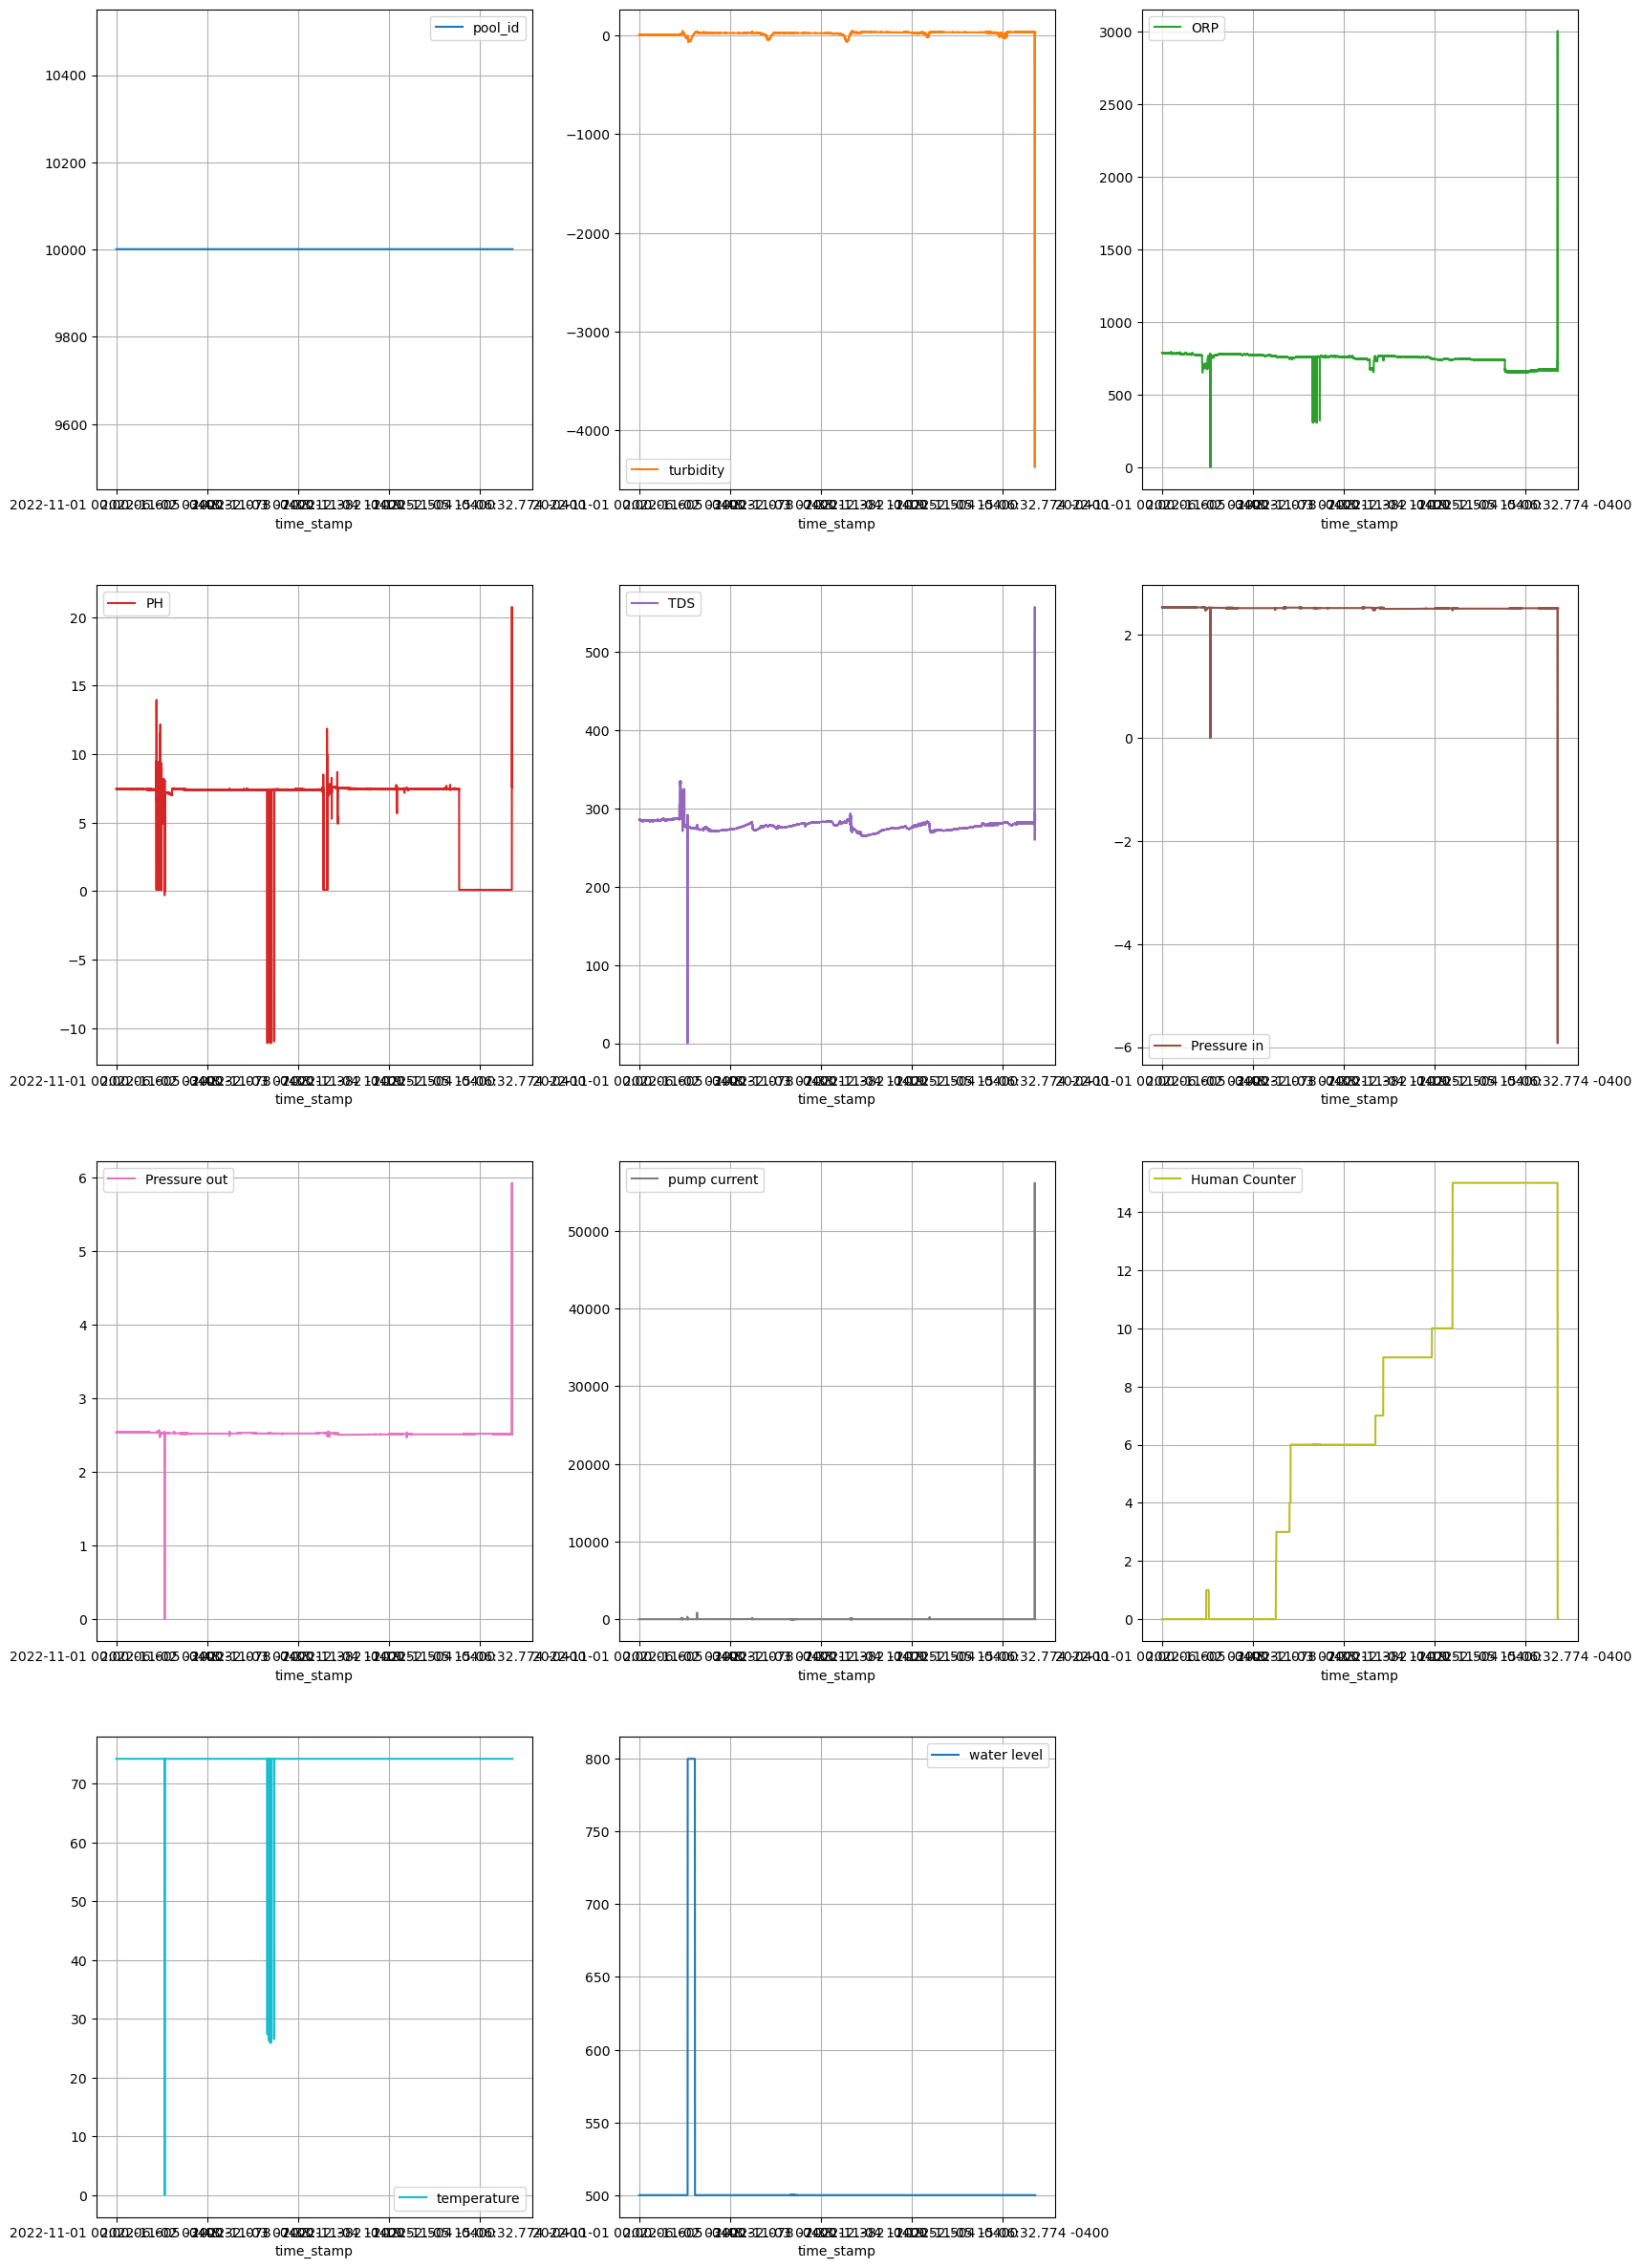

In [9]:
df.plot(subplots = True, grid = True, sharex=False, sharey=False,\
        layout = (int(len(df.columns)/3+1),3), figsize = (20,30));

We know that the sensor is supposed to only have a range from 0-14 so lets drop anything that is outside of that range as it is clearly a sensor issue.

In [10]:
df_clean = df[(df['PH'] >= 0) & (df['PH'] <= 14)]
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pool_id,43591.0,10001.000000,0.000000,10001.0000,10001.00000,10001.00000,10001.00000,10001.00000
turbidity,43591.0,22.910821,16.723076,-66.0706,22.02250,27.35210,33.30830,46.94560
ORP,43591.0,745.237901,37.273908,0.0000,741.40700,758.40600,766.36400,793.21900
PH,43591.0,6.343100,2.600508,0.0000,7.38977,7.41636,7.44927,13.95610
TDS,43591.0,277.773533,6.650318,0.0000,273.95500,277.39100,281.46100,335.06300
Pressure in,43591.0,2.520804,0.019392,0.0000,2.51212,2.52206,2.52387,2.54503
Pressure out,43591.0,2.519516,0.019386,0.0000,2.51085,2.52044,2.52224,2.56330
pump current,43591.0,0.251826,5.756234,0.0000,0.00000,0.00000,0.00000,837.24500
Human Counter,43591.0,7.150719,5.726291,0.0000,0.00000,6.00000,15.00000,15.00000
temperature,43591.0,74.253993,0.502981,0.0000,74.25740,74.25740,74.25740,74.25740


Realistically, we should only have a pH of around 7.2-7.8. Anything outside of that is dangerous and should not be allowed. For the sake of range however, we will keep everything from 7 pH to 8pH.

In [11]:
df_proper = df[(df['PH'] >= 7) & (df['PH'] <= 8)].copy()
df_proper.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pool_id,36667.0,10001.000000,0.000000e+00,10001.00000,10001.00000,10001.00000,10001.00000,10001.00000
turbidity,36667.0,22.947275,1.574392e+01,-66.07060,22.17920,27.03860,32.99490,46.94560
ORP,36667.0,759.705659,1.513900e+01,655.86700,746.38000,760.48600,771.06500,793.21900
PH,36667.0,7.426058,6.676988e-02,7.00370,7.40180,7.42522,7.45434,7.98032
TDS,36667.0,276.966702,5.693086e+00,259.85000,273.16000,276.18000,280.90000,335.00900
Pressure in,36667.0,2.521364,9.401549e-03,2.48011,2.51230,2.52242,2.52695,2.54069
Pressure out,36667.0,2.520008,9.373683e-03,2.46727,2.51103,2.52080,2.52568,2.54593
pump current,36667.0,0.155643,5.293664e+00,0.00000,0.00000,0.00000,0.00000,837.24500
Human Counter,36667.0,6.036981,5.206010e+00,0.00000,0.00000,6.00000,9.00000,15.00000
temperature,36667.0,74.257400,2.188501e-12,74.25740,74.25740,74.25740,74.25740,74.25740


In [12]:
# we will now drop values that are constant after cleaning and then we'll visualize the data

constant = ['pool_id', 'temperature']
df_proper.drop(constant, axis=1,inplace=True)

In [13]:
df_proper.head()

,turbidity,ORP,PH,TDS,Pressure in,Pressure out,pump current,Human Counter,water level
time_stamp,,,,,,,,,
2022-11-01 00:00:06.605 -0400,6.53613,788.607,7.46826,285.584,2.53725,2.53545,0.0,0.0,500.0
2022-11-01 00:00:16.661 -0400,6.37939,788.879,7.46067,285.638,2.53780,2.53617,0.0,0.0,500.0
2022-11-01 00:00:26.768 -0400,5.75244,788.336,7.42585,285.873,2.53870,2.53743,0.0,0.0,500.0
2022-11-01 00:00:36.834 -0400,5.59570,788.065,7.43408,285.855,2.53852,2.53743,0.0,0.0,500.0
2022-11-01 00:00:46.936 -0400,5.59570,788.879,7.43345,285.765,2.53870,2.53725,0.0,0.0,500.0


<AxesSubplot:ylabel='Count'>

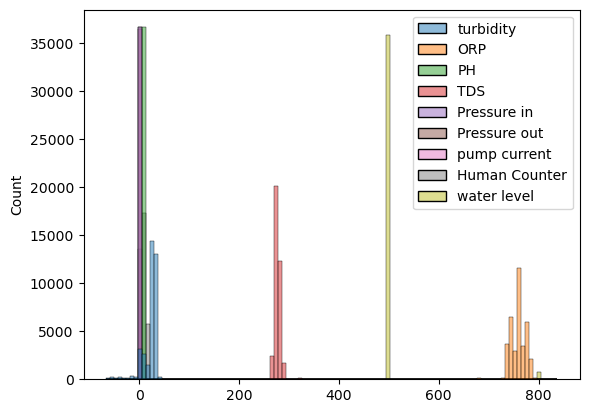

In [14]:
plt.figure()
sns.histplot(df_proper)

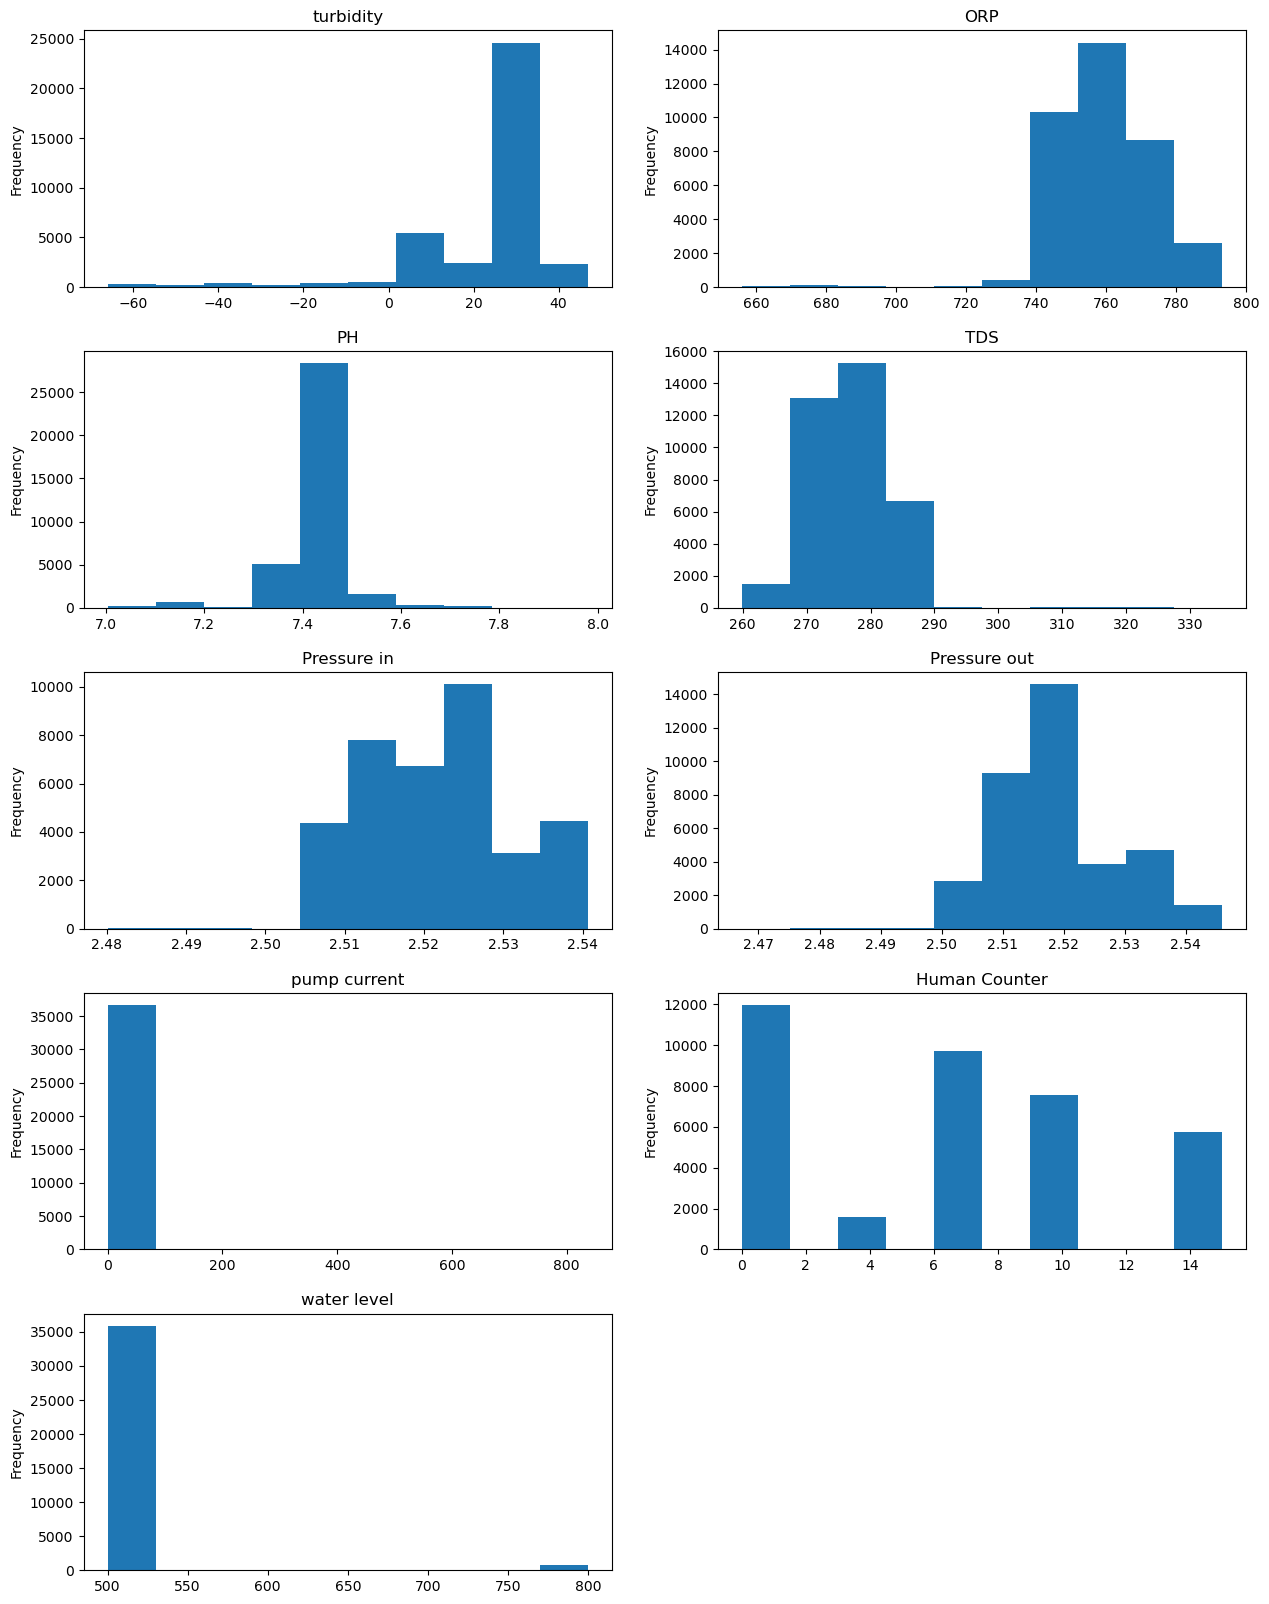

In [15]:
plt.figure(figsize = (15,20))
plt.subplots_adjust(hspace=0.25)

i=0

for col in df_proper.columns:
    i += 1
    ax = plt.subplot(5,2,i)
    df_proper[col].plot(kind = 'hist', ax = ax, title = col)

<AxesSubplot:>

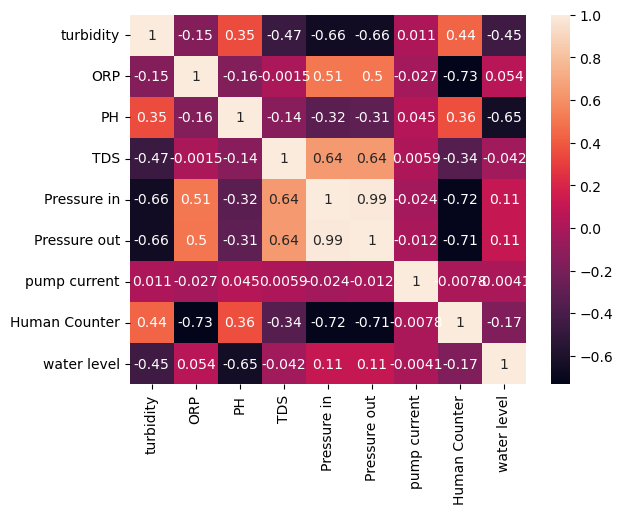

In [16]:
sns.heatmap(df_proper.corr(),annot=True)

In [17]:
# Rename column names
df_proper.columns = df_proper.columns.str.replace(' ', '_')
df_proper.columns

Index(['turbidity', 'ORP', 'PH', 'TDS', 'Pressure_in', 'Pressure_out',
       'pump_current', 'Human_Counter', 'water_level'],
      dtype='object')

In [18]:
df_proper.dtypes

turbidity        float64
ORP              float64
PH               float64
TDS              float64
Pressure_in      float64
Pressure_out     float64
pump_current     float64
Human_Counter    float64
water_level      float64
dtype: object

In [19]:
X = df_proper.drop('PH', axis=1)
y = df_proper['PH']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [21]:
train_data = lgb.Dataset(X_train, y_train, free_raw_data=False)
validation_data = lgb.Dataset(X_test, reference=train_data, free_raw_data=False)

In [22]:
num_iterations = 500

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose':-1,
}

In [23]:
# First we try with just a default lgbm with no changing parameters
bst = lgb.train(params, train_data, valid_sets=[validation_data], verbose_eval=-1, keep_training_booster=True);

In [24]:
eval_score = bst.eval_train()[0]
lgbm_rms = {}
lgbm_rms['initial_lgbm_train'] = eval_score[2]
lgbm_rms

{'initial_lgbm_train': 0.015265157426982694}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

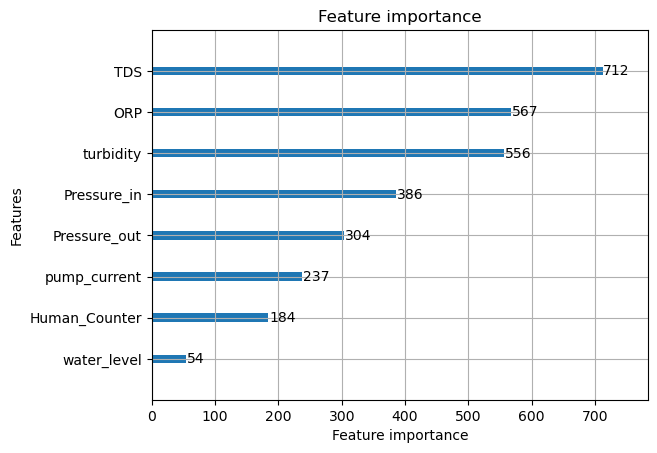

In [25]:
lgb.plot_importance(bst)

In [26]:
y_pred = bst.predict(X_test)

In [27]:
lgbm_rms['initial_lgbm_test'] = mean_squared_error(y_test, y_pred, squared=False)
lgbm_rms

{'initial_lgbm_train': 0.015265157426982694,
 'initial_lgbm_test': 0.01871304139955897}

In [28]:
r2_score(y_test, y_pred)

0.9194145554542847

In [29]:
mean_squared_error(y_test,y_pred, squared=False)

0.01871304139955897

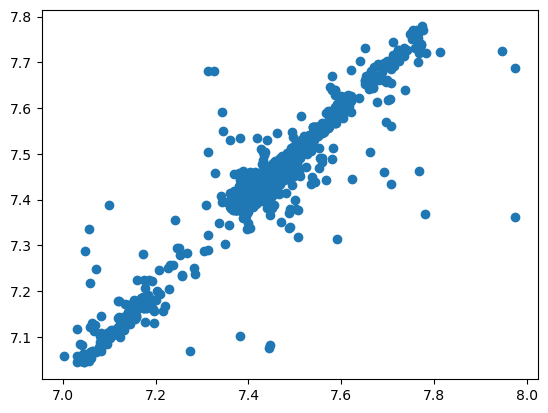

In [30]:
plt.scatter(x=y_test, y=y_pred)

In [31]:
def lgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds), True

In [32]:
def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, learning_rate):
      
        params = {'application':'regression', 'num_iterations': 5000,
                    'early_stopping_round':500, 'learning_rate': 0.05,
                  'metric':'rmse', 'verbose':-1} # Default parameters
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['learning_rate'] = learning_rate
        cv_results = lgb.cv(params, train_data, nfold=5, seed=17,categorical_feature=[], stratified=False,
                            verbose_eval=None)
        # print(cv_results)
        return -np.min(cv_results['rmse-mean'])

In [33]:
pds = {'num_leaves': (10, 200),
          'feature_fraction': (0.1, 0.9),
          'bagging_fraction': (0.8, 1),
          'max_depth': (9, 13 ),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (30, 50),
           'learning_rate': (0.01, 0.1)
      }

In [34]:
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm,pds,random_state=7)
                                  
# Optimize
optimizer.maximize(init_points=15, n_iter=35)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.0259   |  0.8153   |  0.7239   |  0.04946  |  11.89    |  49.56    |  0.05431  |  105.2    |
|  2        | -0.02706  |  0.8144   |  0.3148   |  0.05499  |  11.72    |  46.07    |  0.03871  |  22.53    |
|  3        | -0.02231  |  0.8576   |  0.8277   |  0.0292   |  10.81    |  48.62    |  0.003465 |  124.1    |
|  4        | -0.02817  |  0.99     |  0.2842   |  0.05936  |  12.64    |  32.66    |  0.05282  |  152.6    |
|  5        | -0.02511  |  0.9338   |  0.4742   |  0.02844  |  10.96    |  37.45    |  0.04826  |  79.52    |
|  6        | -0.02454  |  0.9676   |  0.7149   |  0.03826  |  11.29    |  35.52    |  0.04583  |  77.07    |
|  7        | -0.02851  |  0.9315   |  0.3963   |  0.05132  |  11.88    |  38.26    |  0.09074  |  44.29    |
|  8      

|  45       | -0.02478  |  0.9332   |  0.4516   |  0.0696   |  11.24    |  34.66    |  0.04193  |  24.36    |
|  46       | -0.021    |  0.8957   |  0.4646   |  0.07124  |  11.81    |  35.64    |  0.001    |  24.47    |
|  47       | -0.02168  |  1.0      |  0.9      |  0.1      |  13.0     |  50.0     |  0.001    |  129.4    |
|  48       | -0.02508  |  0.9551   |  0.6562   |  0.07184  |  12.72    |  35.53    |  0.03993  |  24.58    |
|  49       | -0.02205  |  0.9384   |  0.8959   |  0.02272  |  11.51    |  35.01    |  0.006343 |  131.3    |
|  50       | -0.0229   |  0.9268   |  0.6597   |  0.04127  |  11.75    |  34.03    |  0.01424  |  130.6    |


In [35]:
optimizer.max['params']

{'bagging_fraction': 0.895692130113902,
 'feature_fraction': 0.4646179619547119,
 'learning_rate': 0.07123544230343082,
 'max_depth': 11.814732436541673,
 'min_child_weight': 35.63589651967184,
 'min_split_gain': 0.001,
 'num_leaves': 24.47324077452041}

In [36]:
tuned_params = optimizer.max['params']
tuned_params['num_leaves'] = int(tuned_params['num_leaves'])
tuned_params['max_depth'] = int(tuned_params['max_depth'])
tuned_params['metric'] = 'rmse'

In [37]:
tuned_bst = lgb.train(tuned_params, train_data, valid_sets=[validation_data], verbose_eval=-1, keep_training_booster=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 25666, number of used features: 8


In [38]:
tuned_eval = tuned_bst.eval_train()[0]
lgbm_rms['tuned_lgbm_train'] = tuned_eval[2]
lgbm_rms

{'initial_lgbm_train': 0.015265157426982694,
 'initial_lgbm_test': 0.01871304139955897,
 'tuned_lgbm_train': 0.01860028003318798}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

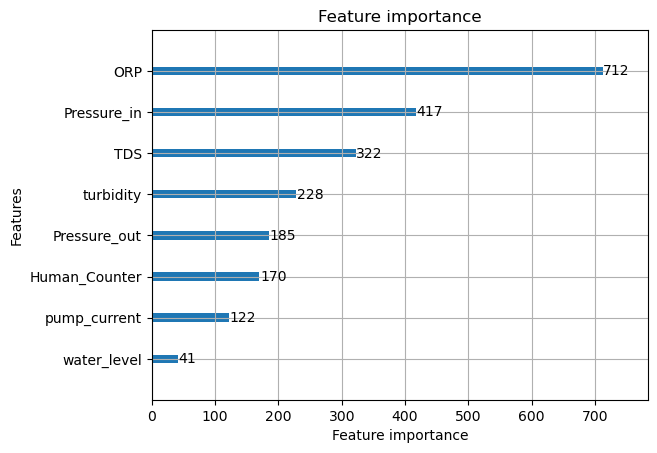

In [39]:
lgb.plot_importance(tuned_bst)

In [40]:
y_tuned_pred = tuned_bst.predict(X_test)

In [41]:
r2_score(y_test, y_tuned_pred)

0.9022906374241988

In [42]:
mean_squared_error(y_test,y_tuned_pred, squared=False)

0.02060554783189559

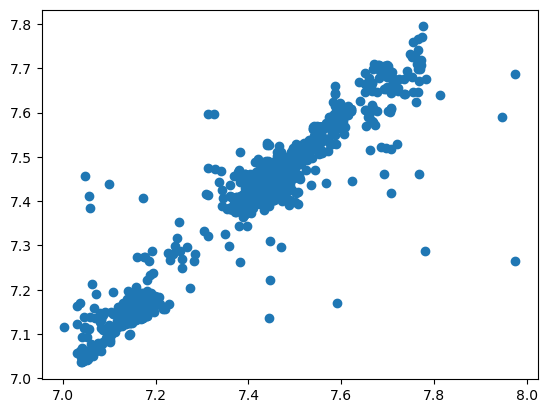

In [43]:
plt.scatter(x=y_test, y=y_tuned_pred)

In [44]:
lgbm_rms['tuned_lgbm_model'] = mean_squared_error(y_test, y_tuned_pred, squared=False)
lgbm_rms

{'initial_lgbm_train': 0.015265157426982694,
 'initial_lgbm_test': 0.01871304139955897,
 'tuned_lgbm_train': 0.01860028003318798,
 'tuned_lgbm_model': 0.02060554783189559}

## TF for fun

In [45]:
X_train.shape

(25666, 8)

In [46]:
def build_and_compile_model(input_layer):
    model = keras.Sequential([
      input_layer, 
      layers.BatchNormalization(),
      layers.Dense(256, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.001)

In [48]:
ph_input = tf.keras.layers.Input(shape=(8,))

In [49]:
ph_model = build_and_compile_model(ph_input)
ph_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 68,385
Trainable params: 68,369
Non-trainable params: 16
_________________________________________________________________


In [50]:
ph_fit = ph_model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    verbose=1, epochs=500,
    callbacks=[early_stopping])

Epoch 1/500
562/562 [==============================] - 2s 3ms/step - loss: 0.6387 - val_loss: 0.1141
Epoch 2/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0726 - val_loss: 0.0690
Epoch 3/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0602 - val_loss: 0.0581
Epoch 4/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0515 - val_loss: 0.0509
Epoch 5/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0516 - val_loss: 0.0465
Epoch 6/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0454 - val_loss: 0.0558
Epoch 7/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0428 - val_loss: 0.0773
Epoch 8/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0380 - val_loss: 0.0535
Epoch 9/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0328
Epoch 10/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0347 - val_lo

562/562 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0167
Epoch 82/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0325
Epoch 83/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0200
Epoch 84/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0355
Epoch 85/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0231
Epoch 86/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0221 - val_loss: 0.0158
Epoch 87/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0154
Epoch 88/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 89/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0167
Epoch 90/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 

Epoch 161/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0199 - val_loss: 0.0137
Epoch 162/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0179 - val_loss: 0.0133
Epoch 163/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0189 - val_loss: 0.0151
Epoch 164/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0212
Epoch 165/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0182 - val_loss: 0.0129
Epoch 166/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0179 - val_loss: 0.0186
Epoch 167/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0173 - val_loss: 0.0136
Epoch 168/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0193 - val_loss: 0.0179
Epoch 169/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0167
Epoch 170/500
562/562 [==============================] - 1s 1ms/step - lo

562/562 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0248
Epoch 241/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0188 - val_loss: 0.0140
Epoch 242/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0147
Epoch 243/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0177 - val_loss: 0.0145
Epoch 244/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0180 - val_loss: 0.0137
Epoch 245/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0121
Epoch 246/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0185 - val_loss: 0.0316
Epoch 247/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0198 - val_loss: 0.0182
Epoch 248/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 249/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0181 - v

562/562 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0270
Epoch 320/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0174 - val_loss: 0.0232
Epoch 321/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 322/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0160 - val_loss: 0.0321
Epoch 323/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0180 - val_loss: 0.0146
Epoch 324/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0164 - val_loss: 0.0172
Epoch 325/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0182
Epoch 326/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0165 - val_loss: 0.0145
Epoch 327/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 328/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0159 - v

562/562 [==============================] - 1s 1ms/step - loss: 0.0168 - val_loss: 0.0136
Epoch 399/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0152 - val_loss: 0.0169
Epoch 400/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 401/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0213
Epoch 402/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0152 - val_loss: 0.0125
Epoch 403/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0147 - val_loss: 0.0125
Epoch 404/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0165 - val_loss: 0.0171
Epoch 405/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 406/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 407/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0158 - v

562/562 [==============================] - 1s 1ms/step - loss: 0.0149 - val_loss: 0.0123
Epoch 478/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 479/500
562/562 [==============================] - 1s 1ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 480/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 481/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0292
Epoch 482/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0195
Epoch 483/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0120
Epoch 484/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0125
Epoch 485/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 486/500
562/562 [==============================] - 1s 2ms/step - loss: 0.0150 - v

In [51]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [PH]')
    plt.legend()
    plt.grid(True)

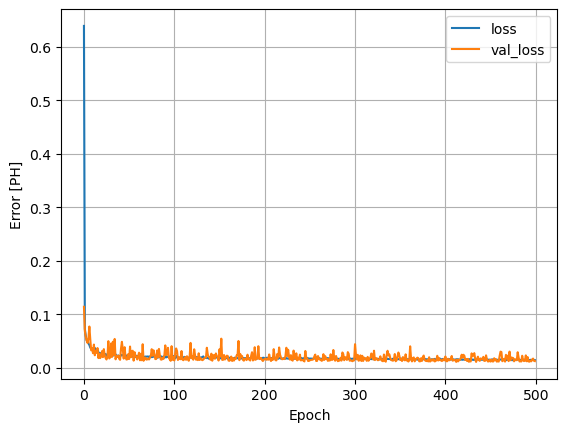

In [52]:
plot_loss(ph_fit)

In [53]:
tf_results = {}
tf_results['dnn_model_earlystop'] = ph_model.evaluate(X_train, y_train, verbose=0)

In [54]:
tf_results

{'dnn_model_earlystop': 0.012901747599244118}

In [55]:
test_pred = ph_model.predict(X_test).flatten()
test_pred

344/344 [==============================] - 0s 778us/step


array([7.3911605, 7.4377446, 7.390355 , ..., 7.4079404, 7.604173 ,
       7.389854 ], dtype=float32)

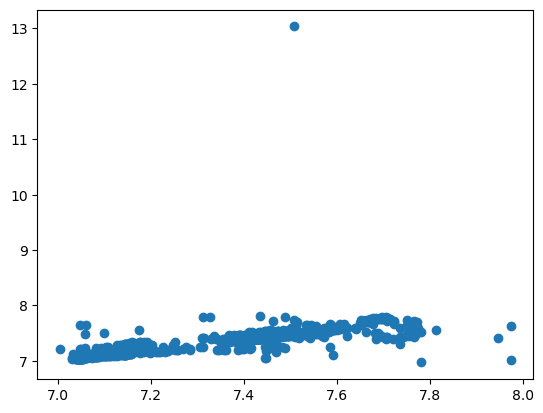

In [56]:
plt.scatter(x=y_test, y=test_pred)

In [57]:
# Find the error on the testing model
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
tf_results['dnn_model_test'] = ph_model.evaluate(X_test, y_test, verbose=0)
tf_results

{'dnn_model_earlystop': 0.012901747599244118,
 'dnn_model_test': 0.013637344352900982}

In [74]:
def model_builder(hp):    
    # Tuning our model
    model = keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(8,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(layers.Dense(units = hp.Int('dense-bot', min_value=25, max_value=350, step=50), activation='relu'))
    
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        model.add(layers.Dense(units=hp.Int('dense_' + str(i), min_value=50, max_value=250, step=25), activation='relu'))
        model.add(layers.Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2])))

    model.add(layers.Dense(1))

    hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

    if hp_optimizer == 'Adam':
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
    elif hp_optimizer == 'SGD':
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
        nesterov=True
        momentum=0.9
        
    model.compile(optimizer = hp_optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [75]:
tuner = kt.tuners.BayesianOptimization(
        model_builder,
        seed=777,
        objective=kt.Objective('root_mean_squared_error',direction="min"),
        max_trials=50,
        overwrite=True,
        directory='.',
        project_name='./ph_keras_tune')

In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.001)

In [77]:
tuner.search(X_train, y_train, epochs=5000,validation_data=(X_test, y_test), callbacks=[early_stopping])

Trial 8 Complete [00h 03m 54s]
root_mean_squared_error: 0.025002947077155113

Best root_mean_squared_error So Far: 0.024107351899147034
Total elapsed time: 00h 38m 36s


UnknownError: Failed to create a NewWriteableFile: .\./ph_keras_tune\oracle.json : The requested operation cannot be performed on a file with a user-mapped section open.
; Unknown error

In [62]:
best_param = tuner.get_best_hyperparameters(1)[0]
best_param.values

{'dense-bot': 325,
 'num_dense_layers': 4,
 'dense_0': 250,
 'dropout_0': 0.0,
 'Optimizer': 'Adam',
 'learning_rate': 0.001,
 'dense_1': 50,
 'dropout_1': 0.2,
 'dense_2': 50,
 'dropout_2': 0.0,
 'dense_3': 50,
 'dropout_3': 0.1}

In [ ]:
def build_tuned_model(input_layer):
    model = keras.Sequential([
          input_layer, 
          layers.BatchNormalization(),
          layers.Dense(325, activation='relu'),
          layers.Dense(250, activation='relu'),
          layers.Dense(50, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(50, activation='relu'),
          layers.Dense(50, activation='relu'),
          layers.Dropout(0.1),
          layers.Dense(1)
        ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [66]:
ph_tuned_model = build_tuned_model(ph_input)
ph_tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 325)               2925      
                                                                 
 dense_9 (Dense)             (None, 250)               81500     
                                                                 
 dense_10 (Dense)            (None, 50)                12550     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                      

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.001)

In [68]:
ph_tuned = ph_tuned_model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    verbose=1, epochs=10000,
    callbacks=[early_stopping])

Epoch 1/10000
562/562 [==============================] - 2s 2ms/step - loss: 0.6503 - val_loss: 0.0382
Epoch 2/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0380
Epoch 3/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0406 - val_loss: 0.0471
Epoch 4/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0474
Epoch 5/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0412 - val_loss: 0.0409
Epoch 6/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0405 - val_loss: 0.0383
Epoch 7/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0408 - val_loss: 0.0379
Epoch 8/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0403 - val_loss: 0.0378
Epoch 9/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0445
Epoch 10/10000
562/562 [==============================] - 1s 2ms/step - l

Epoch 80/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0411 - val_loss: 0.0393
Epoch 81/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0408 - val_loss: 0.0408
Epoch 82/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0404 - val_loss: 0.0441
Epoch 83/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0378
Epoch 84/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0405 - val_loss: 0.0393
Epoch 85/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0410 - val_loss: 0.0404
Epoch 86/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0405 - val_loss: 0.0381
Epoch 87/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0397
Epoch 88/10000
562/562 [==============================] - 1s 2ms/step - loss: 0.0413 - val_loss: 0.0382
Epoch 89/10000
562/562 [==============================] - 1s 2ms

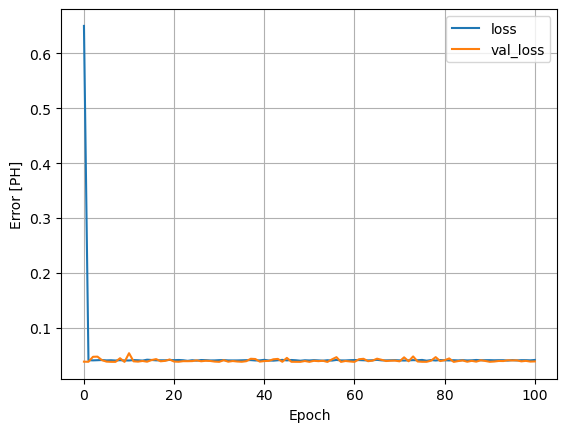

In [69]:
plot_loss(ph_tuned)

In [70]:
tf_results['dnn_model_tuned'] = ph_tuned_model.evaluate(X_train, y_train, verbose=0)
tf_results

{'dnn_model_earlystop': 0.012901747599244118,
 'dnn_model_test': 0.013637344352900982,
 'dnn_model_tuned': 0.03914675489068031}

In [71]:
test_predictions = ph_tuned_model.predict(X_test).flatten()
test_predictions

344/344 [==============================] - 0s 834us/step


array([7.4353743, 7.4353743, 7.4353743, ..., 7.4353743, 7.4353743,
       7.4353743], dtype=float32)

In [72]:
tf_results['dnn_model_tuned'] = ph_tuned_model.evaluate(X_test, y_test, verbose=0)
tf_results

{'dnn_model_earlystop': 0.012901747599244118,
 'dnn_model_test': 0.013637344352900982,
 'dnn_model_tuned': 0.03859039023518562}

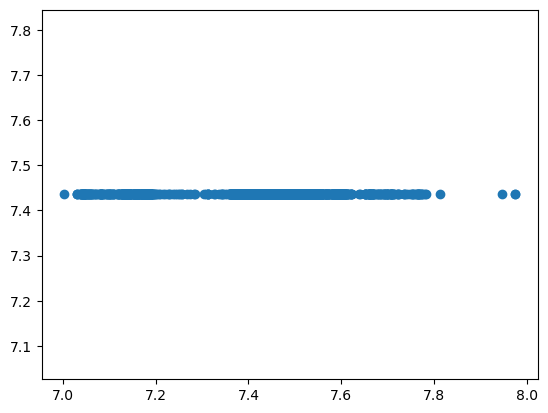

In [73]:
plt.scatter(x=y_test, y=test_predictions)